<a href="https://colab.research.google.com/github/vivekvj18/ML-PROJECT-2/blob/main/ML_2(Neural_91_03).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# CELL 1 — Setup & imports
import os, time, random, gc
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()

# Reproducibility (best-effort)
SEED = 42
os.environ['PYTHONHASHSEED'] = str(SEED)
random.seed(SEED)
np.random.seed(SEED)

# TensorFlow
import tensorflow as tf
tf.random.set_seed(SEED)

print("TF version:", tf.__version__)
gpus = tf.config.experimental.list_physical_devices('GPU')
print("GPUs:", gpus)


TF version: 2.19.0
GPUs: []


In [2]:
# CELL 2 — Load dataset (upload to /content or mount Drive)
DATA_PATH = "covtype.csv"   # change if needed (or mount Drive)

print("Reading:", DATA_PATH)
df = pd.read_csv(DATA_PATH)
print("Loaded shape:", df.shape)
df.head()


Reading: covtype.csv
Loaded shape: (581012, 55)


,Elevation,Aspect,Slope,Horizontal_Distance_To_Hydrology,Vertical_Distance_To_Hydrology,Horizontal_Distance_To_Roadways,Hillshade_9am,Hillshade_Noon,Hillshade_3pm,Horizontal_Distance_To_Fire_Points,...,Soil_Type32,Soil_Type33,Soil_Type34,Soil_Type35,Soil_Type36,Soil_Type37,Soil_Type38,Soil_Type39,Soil_Type40,Cover_Type
0,2596,51,3,258,0,510,221,232,148,6279,...,0,0,0,0,0,0,0,0,0,5
1,2590,56,2,212,-6,390,220,235,151,6225,...,0,0,0,0,0,0,0,0,0,5
2,2804,139,9,268,65,3180,234,238,135,6121,...,0,0,0,0,0,0,0,0,0,2
3,2785,155,18,242,118,3090,238,238,122,6211,...,0,0,0,0,0,0,0,0,0,2
4,2595,45,2,153,-1,391,220,234,150,6172,...,0,0,0,0,0,0,0,0,0,5


In [3]:
# CELL 3 — Columns, cleaning, feature matrix and zero-based labels
# Correct continuous columns
continuous_cols = [
    'Elevation','Aspect','Slope',
    'Horizontal_Distance_To_Hydrology','Vertical_Distance_To_Hydrology',
    'Horizontal_Distance_To_Roadways','Hillshade_9am','Hillshade_Noon','Hillshade_3pm',
    'Horizontal_Distance_To_Fire_Points'
]

# Identify target and features
target_col = 'Cover_Type' if 'Cover_Type' in df.columns else df.columns[-1]
feature_cols = [c for c in df.columns if c != target_col]
binary_cols = [c for c in feature_cols if c not in continuous_cols]

print("Target:", target_col)
print("Features total:", len(feature_cols), "| continuous:", len(continuous_cols), "| binary:", len(binary_cols))

# Basic cleaning
df = df.dropna(subset=[target_col])
df = df.replace([np.inf, -np.inf], np.nan).dropna().reset_index(drop=True)
df[target_col] = df[target_col].astype(int)

# Build feature matrix X_all: scaled continuous + binary cols appended
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
X_cont_scaled = scaler.fit_transform(df[continuous_cols])
X_all = np.hstack([X_cont_scaled, df[binary_cols].values]).astype(np.float32)

# Convert labels 1..7 -> 0..6 for Keras sparse loss
y_orig = df[target_col].values.astype(int)        # keep original for reference
y = y_orig - 1                                    # zero-based

print("X_all shape:", X_all.shape, "y shape:", y.shape)
print("Original label range:", y_orig.min(), "to", y_orig.max())
print("Zero-based label range:", y.min(), "to", y.max())


Target: Cover_Type
Features total: 54 | continuous: 10 | binary: 44
X_all shape: (581012, 54) y shape: (581012,)
Original label range: 1 to 7
Zero-based label range: 0 to 6


In [4]:
# CELL 4 — Stratified train/test split and compute class weights
from sklearn.model_selection import train_test_split
from sklearn.utils.class_weight import compute_class_weight

X_train, X_test, y_train, y_test = train_test_split(
    X_all, y, test_size=0.20, stratify=y, random_state=SEED
)
print("Train shape:", X_train.shape, "Test shape:", X_test.shape)

classes = np.unique(y_train)
class_weights_arr = compute_class_weight(class_weight='balanced', classes=classes, y=y_train)
class_weight_dict = {int(cls): float(w) for cls, w in zip(classes, class_weights_arr)}
print("Class weight dict (zero-based):", class_weight_dict)


Train shape: (464809, 54) Test shape: (116203, 54)
Class weight dict (zero-based): {0: 0.39181272253992233, 1: 0.29298131712974634, 2: 2.3214797648598298, 3: 30.209866112049916, 4: 8.743914368486399, 5: 4.779133850171708, 6: 4.046884794873581}


In [5]:
# Paste-replace your Cell 5 with this cell
from tensorflow.keras import layers, models, regularizers
import tensorflow as tf
import numpy as np

BATCH_SIZE = 1024 # Moved from Cell 6

input_dim = X_train.shape[1]
n_classes = len(classes)

def build_mlp_v2(input_dim, n_classes, lr=5e-4, l2_reg=1e-5, dropout_rate=0.15):
    inp = layers.Input(shape=(input_dim,))
    x = layers.BatchNormalization()(inp)

    x = layers.Dense(1024, activation='relu',
                     kernel_regularizer=regularizers.l2(l2_reg))(x)
    x = layers.BatchNormalization()(x)
    x = layers.Dropout(dropout_rate)(x)

    x = layers.Dense(512, activation='relu',
                     kernel_regularizer=regularizers.l2(l2_reg))(x)
    x = layers.BatchNormalization()(x)
    x = layers.Dropout(dropout_rate)(x)

    x = layers.Dense(256, activation='relu',
                     kernel_regularizer=regularizers.l2(l2_reg))(x)
    x = layers.BatchNormalization()(x)

    out = layers.Dense(n_classes, activation='softmax', dtype='float32')(x)

    model = models.Model(inputs=inp, outputs=out)

    # lr schedule: cosine decay for stability
    steps_per_epoch = int(np.ceil(X_train.shape[0] / BATCH_SIZE))
    decay_steps = max(1, steps_per_epoch * 30)   # ~30 epochs worth
    lr_schedule = tf.keras.optimizers.schedules.CosineDecay(initial_learning_rate=lr,
                                                            decay_steps=decay_steps)
    opt = tf.keras.optimizers.Adam(learning_rate=lr_schedule)

    model.compile(optimizer=opt,
                  loss='sparse_categorical_crossentropy',
                  metrics=['sparse_categorical_accuracy'])
    return model

# Instantiate
model = build_mlp_v2(input_dim, n_classes, lr=5e-4, l2_reg=1e-5, dropout_rate=0.15)
model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 54)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 54)             │           216 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 1024)           │        56,320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 1024)           │         4,096 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 1024)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 512)            │       524,800 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 512)            │         2,048 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 256)            │       131,328 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ (None, 256)            │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 7)              │         1,799 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 721,631 (2.75 MB)

 Trainable params: 717,939 (2.74 MB)

 Non-trainable params: 3,692 (14.42 KB)

In [6]:
from tensorflow.keras import callbacks
import time

BATCH_SIZE = 1024
EPOCHS = 200

es = callbacks.EarlyStopping(
    monitor='val_loss', patience=12, mode='min',
    restore_best_weights=True, verbose=1
)

rlr = callbacks.ReduceLROnPlateau(
    monitor='val_loss', factor=0.5, patience=6, verbose=1, min_lr=1e-6
)

mc = callbacks.ModelCheckpoint("mlp_best_full_v2.h5",
                               monitor='val_sparse_categorical_accuracy',
                               save_best_only=True, mode='max', verbose=1)

t0 = time.time()
history = model.fit(
    X_train, y_train,
    validation_split=0.10,
    epochs=EPOCHS,
    batch_size=BATCH_SIZE,
    class_weight=class_weight_dict,
    callbacks=[es, rlr, mc],
    verbose=2
)
t1 = time.time()
print("Training finished. Time (s):", round(t1 - t0, 1))


Epoch 1/200

Epoch 1: val_sparse_categorical_accuracy improved from -inf to 0.69108, saving model to mlp_best_full_v2.h5


409/409 - 62s - 151ms/step - loss: 0.7743 - sparse_categorical_accuracy: 0.6132 - val_loss: 0.7537 - val_sparse_categorical_accuracy: 0.6911 - learning_rate: 4.9889e-04
Epoch 2/200

Epoch 2: val_sparse_categorical_accuracy improved from 0.69108 to 0.71933, saving model to mlp_best_full_v2.h5


409/409 - 81s - 197ms/step - loss: 0.5597 - sparse_categorical_accuracy: 0.6910 - val_loss: 0.7121 - val_sparse_categorical_accuracy: 0.7193 - learning_rate: 4.9556e-04
Epoch 3/200

Epoch 3: val_sparse_categorical_accuracy improved from 0.71933 to 0.74764, saving model to mlp_best_full_v2.h5


409/409 - 80s - 197ms/step - loss: 0.4853 - sparse_categorical_accuracy: 0.7284 - val_loss: 0.6344 - val_sparse_categorical_accuracy: 0.7476 - learning_rate: 4.9005e-04
Epoch 4/200

Epoch 4: val_sparse_categorical_accuracy improved from 0.74764 to 0.77419, saving model to mlp_best_full_v2.h5


409/409 - 57s - 140ms/step - loss: 0.4310 - sparse_categorical_accuracy: 0.7563 - val_loss: 0.5670 - val_sparse_categorical_accuracy: 0.7742 - learning_rate: 4.8241e-04
Epoch 5/200

Epoch 5: val_sparse_categorical_accuracy improved from 0.77419 to 0.79058, saving model to mlp_best_full_v2.h5


409/409 - 56s - 137ms/step - loss: 0.3901 - sparse_categorical_accuracy: 0.7770 - val_loss: 0.5331 - val_sparse_categorical_accuracy: 0.7906 - learning_rate: 4.7270e-04
Epoch 6/200

Epoch 6: val_sparse_categorical_accuracy improved from 0.79058 to 0.80702, saving model to mlp_best_full_v2.h5


409/409 - 84s - 206ms/step - loss: 0.3577 - sparse_categorical_accuracy: 0.7940 - val_loss: 0.5033 - val_sparse_categorical_accuracy: 0.8070 - learning_rate: 4.6101e-04
Epoch 7/200

Epoch 7: val_sparse_categorical_accuracy improved from 0.80702 to 0.81709, saving model to mlp_best_full_v2.h5


409/409 - 56s - 137ms/step - loss: 0.3327 - sparse_categorical_accuracy: 0.8069 - val_loss: 0.4761 - val_sparse_categorical_accuracy: 0.8171 - learning_rate: 4.4744e-04
Epoch 8/200

Epoch 8: val_sparse_categorical_accuracy improved from 0.81709 to 0.83268, saving model to mlp_best_full_v2.h5


409/409 - 57s - 140ms/step - loss: 0.3118 - sparse_categorical_accuracy: 0.8178 - val_loss: 0.4364 - val_sparse_categorical_accuracy: 0.8327 - learning_rate: 4.3212e-04
Epoch 9/200

Epoch 9: val_sparse_categorical_accuracy improved from 0.83268 to 0.83953, saving model to mlp_best_full_v2.h5


409/409 - 57s - 140ms/step - loss: 0.2944 - sparse_categorical_accuracy: 0.8268 - val_loss: 0.4210 - val_sparse_categorical_accuracy: 0.8395 - learning_rate: 4.1517e-04
Epoch 10/200

Epoch 10: val_sparse_categorical_accuracy improved from 0.83953 to 0.84551, saving model to mlp_best_full_v2.h5


409/409 - 82s - 200ms/step - loss: 0.2774 - sparse_categorical_accuracy: 0.8354 - val_loss: 0.4101 - val_sparse_categorical_accuracy: 0.8455 - learning_rate: 3.9676e-04
Epoch 11/200

Epoch 11: val_sparse_categorical_accuracy improved from 0.84551 to 0.85467, saving model to mlp_best_full_v2.h5


409/409 - 82s - 200ms/step - loss: 0.2669 - sparse_categorical_accuracy: 0.8417 - val_loss: 0.3845 - val_sparse_categorical_accuracy: 0.8547 - learning_rate: 3.7704e-04
Epoch 12/200

Epoch 12: val_sparse_categorical_accuracy improved from 0.85467 to 0.86306, saving model to mlp_best_full_v2.h5


409/409 - 57s - 140ms/step - loss: 0.2520 - sparse_categorical_accuracy: 0.8484 - val_loss: 0.3652 - val_sparse_categorical_accuracy: 0.8631 - learning_rate: 3.5619e-04
Epoch 13/200

Epoch 13: val_sparse_categorical_accuracy improved from 0.86306 to 0.86967, saving model to mlp_best_full_v2.h5


409/409 - 56s - 137ms/step - loss: 0.2412 - sparse_categorical_accuracy: 0.8537 - val_loss: 0.3558 - val_sparse_categorical_accuracy: 0.8697 - learning_rate: 3.3440e-04
Epoch 14/200

Epoch 14: val_sparse_categorical_accuracy improved from 0.86967 to 0.87442, saving model to mlp_best_full_v2.h5


409/409 - 60s - 146ms/step - loss: 0.2316 - sparse_categorical_accuracy: 0.8587 - val_loss: 0.3380 - val_sparse_categorical_accuracy: 0.8744 - learning_rate: 3.1186e-04
Epoch 15/200

Epoch 15: val_sparse_categorical_accuracy improved from 0.87442 to 0.87692, saving model to mlp_best_full_v2.h5


409/409 - 56s - 137ms/step - loss: 0.2241 - sparse_categorical_accuracy: 0.8634 - val_loss: 0.3327 - val_sparse_categorical_accuracy: 0.8769 - learning_rate: 2.8877e-04
Epoch 16/200

Epoch 16: val_sparse_categorical_accuracy improved from 0.87692 to 0.88292, saving model to mlp_best_full_v2.h5


409/409 - 56s - 137ms/step - loss: 0.2158 - sparse_categorical_accuracy: 0.8672 - val_loss: 0.3204 - val_sparse_categorical_accuracy: 0.8829 - learning_rate: 2.6533e-04
Epoch 17/200

Epoch 17: val_sparse_categorical_accuracy improved from 0.88292 to 0.88550, saving model to mlp_best_full_v2.h5


409/409 - 57s - 140ms/step - loss: 0.2089 - sparse_categorical_accuracy: 0.8713 - val_loss: 0.3120 - val_sparse_categorical_accuracy: 0.8855 - learning_rate: 2.4176e-04
Epoch 18/200

Epoch 18: val_sparse_categorical_accuracy improved from 0.88550 to 0.88985, saving model to mlp_best_full_v2.h5


409/409 - 82s - 200ms/step - loss: 0.2000 - sparse_categorical_accuracy: 0.8747 - val_loss: 0.3013 - val_sparse_categorical_accuracy: 0.8898 - learning_rate: 2.1825e-04
Epoch 19/200

Epoch 19: val_sparse_categorical_accuracy improved from 0.88985 to 0.89256, saving model to mlp_best_full_v2.h5


409/409 - 82s - 200ms/step - loss: 0.1926 - sparse_categorical_accuracy: 0.8785 - val_loss: 0.2938 - val_sparse_categorical_accuracy: 0.8926 - learning_rate: 1.9504e-04
Epoch 20/200

Epoch 20: val_sparse_categorical_accuracy improved from 0.89256 to 0.89731, saving model to mlp_best_full_v2.h5


409/409 - 57s - 140ms/step - loss: 0.1884 - sparse_categorical_accuracy: 0.8816 - val_loss: 0.2826 - val_sparse_categorical_accuracy: 0.8973 - learning_rate: 1.7231e-04
Epoch 21/200

Epoch 21: val_sparse_categorical_accuracy did not improve from 0.89731
409/409 - 57s - 140ms/step - loss: 0.1824 - sparse_categorical_accuracy: 0.8841 - val_loss: 0.2817 - val_sparse_categorical_accuracy: 0.8965 - learning_rate: 1.5027e-04
Epoch 22/200

Epoch 22: val_sparse_categorical_accuracy improved from 0.89731 to 0.90024, saving model to mlp_best_full_v2.h5


409/409 - 58s - 141ms/step - loss: 0.1777 - sparse_categorical_accuracy: 0.8863 - val_loss: 0.2753 - val_sparse_categorical_accuracy: 0.9002 - learning_rate: 1.2912e-04
Epoch 23/200

Epoch 23: val_sparse_categorical_accuracy improved from 0.90024 to 0.90347, saving model to mlp_best_full_v2.h5


409/409 - 80s - 197ms/step - loss: 0.1714 - sparse_categorical_accuracy: 0.8884 - val_loss: 0.2656 - val_sparse_categorical_accuracy: 0.9035 - learning_rate: 1.0904e-04
Epoch 24/200

Epoch 24: val_sparse_categorical_accuracy improved from 0.90347 to 0.90433, saving model to mlp_best_full_v2.h5


409/409 - 83s - 203ms/step - loss: 0.1683 - sparse_categorical_accuracy: 0.8909 - val_loss: 0.2641 - val_sparse_categorical_accuracy: 0.9043 - learning_rate: 9.0218e-05
Epoch 25/200

Epoch 25: val_sparse_categorical_accuracy improved from 0.90433 to 0.90661, saving model to mlp_best_full_v2.h5


409/409 - 56s - 138ms/step - loss: 0.1650 - sparse_categorical_accuracy: 0.8923 - val_loss: 0.2577 - val_sparse_categorical_accuracy: 0.9066 - learning_rate: 7.2816e-05
Epoch 26/200

Epoch 26: val_sparse_categorical_accuracy improved from 0.90661 to 0.90727, saving model to mlp_best_full_v2.h5


409/409 - 82s - 200ms/step - loss: 0.1613 - sparse_categorical_accuracy: 0.8935 - val_loss: 0.2570 - val_sparse_categorical_accuracy: 0.9073 - learning_rate: 5.6990e-05
Epoch 27/200

Epoch 27: val_sparse_categorical_accuracy improved from 0.90727 to 0.90824, saving model to mlp_best_full_v2.h5


409/409 - 82s - 201ms/step - loss: 0.1593 - sparse_categorical_accuracy: 0.8950 - val_loss: 0.2517 - val_sparse_categorical_accuracy: 0.9082 - learning_rate: 4.2880e-05
Epoch 28/200

Epoch 28: val_sparse_categorical_accuracy improved from 0.90824 to 0.90902, saving model to mlp_best_full_v2.h5


409/409 - 57s - 140ms/step - loss: 0.1552 - sparse_categorical_accuracy: 0.8966 - val_loss: 0.2496 - val_sparse_categorical_accuracy: 0.9090 - learning_rate: 3.0613e-05
Epoch 29/200

Epoch 29: val_sparse_categorical_accuracy improved from 0.90902 to 0.90955, saving model to mlp_best_full_v2.h5


409/409 - 57s - 140ms/step - loss: 0.1534 - sparse_categorical_accuracy: 0.8972 - val_loss: 0.2486 - val_sparse_categorical_accuracy: 0.9096 - learning_rate: 2.0297e-05
Epoch 30/200

Epoch 30: val_sparse_categorical_accuracy improved from 0.90955 to 0.91050, saving model to mlp_best_full_v2.h5


409/409 - 87s - 212ms/step - loss: 0.1515 - sparse_categorical_accuracy: 0.8978 - val_loss: 0.2471 - val_sparse_categorical_accuracy: 0.9105 - learning_rate: 1.2023e-05
Epoch 31/200

Epoch 31: val_sparse_categorical_accuracy did not improve from 0.91050
409/409 - 77s - 188ms/step - loss: 0.1504 - sparse_categorical_accuracy: 0.8981 - val_loss: 0.2467 - val_sparse_categorical_accuracy: 0.9102 - learning_rate: 5.8658e-06
Epoch 32/200

Epoch 32: val_sparse_categorical_accuracy did not improve from 0.91050
409/409 - 58s - 142ms/step - loss: 0.1513 - sparse_categorical_accuracy: 0.8987 - val_loss: 0.2468 - val_sparse_categorical_accuracy: 0.9105 - learning_rate: 1.8799e-06
Epoch 33/200

Epoch 33: val_sparse_categorical_accuracy improved from 0.91050 to 0.91052, saving model to mlp_best_full_v2.h5


409/409 - 82s - 201ms/step - loss: 0.1500 - sparse_categorical_accuracy: 0.8989 - val_loss: 0.2466 - val_sparse_categorical_accuracy: 0.9105 - learning_rate: 1.0061e-07
Epoch 34/200

Epoch 34: val_sparse_categorical_accuracy improved from 0.91052 to 0.91061, saving model to mlp_best_full_v2.h5


409/409 - 56s - 138ms/step - loss: 0.1496 - sparse_categorical_accuracy: 0.8988 - val_loss: 0.2465 - val_sparse_categorical_accuracy: 0.9106 - learning_rate: 0.0000e+00
Epoch 35/200

Epoch 35: val_sparse_categorical_accuracy did not improve from 0.91061
409/409 - 57s - 140ms/step - loss: 0.1497 - sparse_categorical_accuracy: 0.8985 - val_loss: 0.2467 - val_sparse_categorical_accuracy: 0.9104 - learning_rate: 0.0000e+00
Epoch 36/200

Epoch 36: val_sparse_categorical_accuracy did not improve from 0.91061
409/409 - 56s - 137ms/step - loss: 0.1495 - sparse_categorical_accuracy: 0.8987 - val_loss: 0.2466 - val_sparse_categorical_accuracy: 0.9105 - learning_rate: 0.0000e+00
Epoch 37/200

Epoch 37: val_sparse_categorical_accuracy did not improve from 0.91061
409/409 - 57s - 140ms/step - loss: 0.1499 - sparse_categorical_accuracy: 0.8988 - val_loss: 0.2466 - val_sparse_categorical_accuracy: 0.9105 - learning_rate: 0.0000e+00
Epoch 38/200

Epoch 38: val_sparse_categorical_accuracy did not impro

409/409 - 81s - 199ms/step - loss: 0.1494 - sparse_categorical_accuracy: 0.8990 - val_loss: 0.2464 - val_sparse_categorical_accuracy: 0.9106 - learning_rate: 0.0000e+00
Epoch 45/200

Epoch 45: val_sparse_categorical_accuracy improved from 0.91063 to 0.91067, saving model to mlp_best_full_v2.h5


409/409 - 81s - 199ms/step - loss: 0.1498 - sparse_categorical_accuracy: 0.8989 - val_loss: 0.2465 - val_sparse_categorical_accuracy: 0.9107 - learning_rate: 0.0000e+00
Epoch 46/200

Epoch 46: val_sparse_categorical_accuracy did not improve from 0.91067
409/409 - 82s - 200ms/step - loss: 0.1509 - sparse_categorical_accuracy: 0.8987 - val_loss: 0.2467 - val_sparse_categorical_accuracy: 0.9104 - learning_rate: 0.0000e+00
Epoch 47/200

Epoch 47: val_sparse_categorical_accuracy did not improve from 0.91067
409/409 - 57s - 140ms/step - loss: 0.1501 - sparse_categorical_accuracy: 0.8983 - val_loss: 0.2466 - val_sparse_categorical_accuracy: 0.9105 - learning_rate: 0.0000e+00
Epoch 48/200

Epoch 48: val_sparse_categorical_accuracy did not improve from 0.91067
409/409 - 56s - 137ms/step - loss: 0.1493 - sparse_categorical_accuracy: 0.8983 - val_loss: 0.2467 - val_sparse_categorical_accuracy: 0.9105 - learning_rate: 0.0000e+00
Epoch 49/200

Epoch 49: val_sparse_categorical_accuracy did not impro

TEST Accuracy : 0.9103
TEST Macro-F1: 0.8655

Classification Report (labels 1..7):

              precision    recall  f1-score   support

           1     0.9155    0.9144    0.9149     42368
           2     0.9489    0.8930    0.9201     56661
           3     0.9222    0.9312    0.9267      7151
           4     0.7458    0.9617    0.8401       549
           5     0.5276    0.9868    0.6876      1899
           6     0.8020    0.9505    0.8699      3473
           7     0.8208    0.9937    0.8990      4102

    accuracy                         0.9103    116203
   macro avg     0.8118    0.9473    0.8655    116203
weighted avg     0.9183    0.9103    0.9122    116203



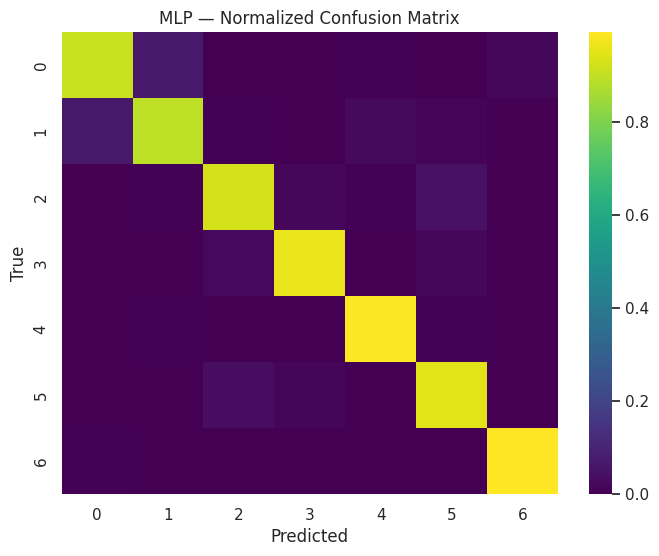

In [8]:
# CELL 7 — Evaluate on test set and report (convert labels back to 1..7)
from sklearn.metrics import accuracy_score, f1_score, classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

# load best weights (optional)
model.load_weights("mlp_best_full_v2.h5")

y_pred_proba = model.predict(X_test, batch_size=1024, verbose=0)
y_pred_zero = np.argmax(y_pred_proba, axis=1).astype(int)

# convert to original label space 1..7
y_test_orig = y_test + 1
y_pred_orig = y_pred_zero + 1

acc = accuracy_score(y_test_orig, y_pred_orig)
f1_macro = f1_score(y_test_orig, y_pred_orig, average='macro')

print("TEST Accuracy :", round(acc,4))
print("TEST Macro-F1:", round(f1_macro,4))
print("\nClassification Report (labels 1..7):\n")
print(classification_report(y_test_orig, y_pred_orig, digits=4))

# Normalized confusion matrix
cm = confusion_matrix(y_test_orig, y_pred_orig)
plt.figure(figsize=(8,6))
sns.heatmap(cm / cm.sum(axis=1, keepdims=True), cmap='viridis')
plt.title("MLP — Normalized Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.show()